In [2]:
import numpy as np 
from astropy import table
from astropy.table import Table
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
import pickle
#Function to create color color plots
def colorsthres(c1, c2, c3, prob, cmask, iymin, xlabel1 = 'i-y', 
                             ylabel1 = 'r-i', xlabel2 = 'i-y', ylabel2 = 'i-z',
                             title1 = '',
                             title2 = '',
                             xlim1= (-2, 2), 
                             ylim1=(0, 3), xlim2 = (-2, 2), ylim2 = (0, 3),**c_kwargs):
    
    #pcmask = np.logical_and.reduce(prob,colormaskx)

    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2,  constrained_layout = True)
    
    sd1 = ax1.scatter(c3, c2, c=prob[cmask] , cmap = 'viridis', s = 5, alpha = .05 ,vmin=0, vmax=1, **c_kwargs)
    sd2 = ax2.scatter(c3, c1, c=prob[cmask] , cmap = 'viridis', s = 5, alpha = .05, vmin=0, vmax=1, **c_kwargs)
    sdummy = ax1.scatter(x = 100, y = 100, c=prob[0], cmap = 'viridis', s = 5, alpha = 1 ,vmin=0, vmax=1, **c_kwargs)
    x = np.arange(0.28 , 2, .05)
    ax1.plot(x + 0.08 ,x, c = 'black')
    ax1.axvline(x = iymin , ymax = .35 , c = 'black') 
    ax1.set_xlim(*xlim1)
    ax1.set_ylim(*ylim1)
    ax1.set_xlabel(xlabel1, fontsize = 15)
    ax1.set_ylabel(ylabel1, fontsize = 15)
    ax2.set_xlim(*xlim2)
    ax2.set_ylim(*ylim2)
    ax2.set_xlabel(xlabel2, fontsize = 15)
    ax2.set_ylabel(ylabel2, fontsize = 15)
    ax2.axvline(x = 0.35 , c = 'black') 
    cbar = plt.colorbar(sdummy)
    cbar.set_label('predict_probability')
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    
    return fig

# Specify the version of the catalog and the folder with the input/output files

# Loading the Farmer version of the COSMOS2020 Cat
dir_in1 ='/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/data/'  
dir_out1 = '/Users/yokisalcedo/Desktop/data/' # the directory where the output of this notebook will be stored
# Upload the main catalogue
cat = table.Table.read(dir_in1+'COSMOS2020_Farmer_jan_processed.fits',format='fits',hdu=1).to_pandas()

#All possible non-redundant colors are listed below:
#u: ug ,ur ,ui ,uz , uy
#g: gr, gi, gz, gy
#r: ri, rz, ry
#i: iz, iy
#z: zy

ug = cat['CFHT_u_MAG'] - cat['HSC_g_MAG'] 
ur = cat['CFHT_u_MAG'] - cat['HSC_r_MAG']
ui = cat['CFHT_u_MAG'] - cat['HSC_i_MAG']
uz = cat['CFHT_u_MAG'] - cat['HSC_z_MAG'] 
uy = cat['CFHT_u_MAG'] - cat['HSC_y_MAG']
gr = cat['HSC_g_MAG'] - cat['HSC_r_MAG']
gi = cat['HSC_g_MAG'] - cat['HSC_i_MAG']
gz = cat['HSC_g_MAG'] - cat['HSC_z_MAG']
gy = cat['HSC_g_MAG'] - cat['HSC_y_MAG']
ri = cat['HSC_r_MAG'] - cat['HSC_i_MAG']
rz = cat['HSC_r_MAG'] - cat['HSC_z_MAG']
ry = cat['HSC_r_MAG'] - cat['HSC_y_MAG']
iz = cat['HSC_i_MAG'] - cat['HSC_z_MAG']
iy = cat['HSC_i_MAG'] - cat['HSC_y_MAG']
zy = cat['HSC_z_MAG'] - cat['HSC_y_MAG']
r = cat['HSC_r_MAG']
g = cat['HSC_g_MAG']
i = cat['HSC_i_MAG']
y = cat['HSC_y_MAG']
z = cat['HSC_z_MAG']

cat['ug']= ug
cat['ur']= ur
cat['ui']=ui
cat['uz']=uz
cat['uy']=uy
cat['gr']=gr
cat['gi']=gi
cat['gz']=gz
cat['gy']=gy
cat['ri']=ri
cat['rz']=rz
cat['ry']=ry
cat['iz']=iz
cat['iy']=iy
cat['zy']=zy
cat['HSC_r_MAG'] = r
cat['HSC_g_MAG'] = g
cat['HSC_i_MAG'] = i
cat['HSC_y_MAG'] = y
cat['HSC_z_MAG'] = z



colormaskx = np.logical_and.reduce(( np.isfinite(cat['photoz']),
                                    np.isfinite(cat['CFHT_u_MAG']),
                                    np.isfinite(cat['HSC_g_MAG']),
                                    np.isfinite(cat['HSC_r_MAG']),
                                    np.isfinite(cat['HSC_i_MAG']),
                                    np.isfinite(cat['HSC_z_MAG']),
                                    np.isfinite(cat['HSC_y_MAG']),
                                    (np.logical_or(cat['HSC_g_MAG']< 24, cat['HSC_r_MAG']< 24))))







In [4]:
#Here we defind our narrow and broad zcut, all RFs and all colors
#(xalln, yn, zalln, galln), (xallb, yb, zallb , gallb )
zcutn = np.logical_and(cat['photoz'] > 1.05, cat['photoz'] < 1.45)
zcutb = np.logical_and(cat['photoz'] > 1.05, cat['photoz'] < 1.55)
xalln = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]
xallb = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]
zalln = cat['photoz'][colormaskx]
zallb = cat['photoz'][colormaskx]
galln = cat.loc[colormaskx,['HSC_g_MAG']]
gallb = cat.loc[colormaskx,['HSC_g_MAG']]
yn = zcutn[colormaskx]
yb = zcutb[colormaskx]
ralln = cat['HSC_r_MAG'][colormaskx]
rallb = cat['HSC_r_MAG'][colormaskx]
rialln = cat['HSC_r_MAG'][colormaskx] - cat['HSC_i_MAG'][colormaskx]

#Here, we split the data into training and testing sets
xallb_train, xallb_test, yb_train, yb_test, zallb_train, zallb_test, gallb_train, gallb_test, rallb_train, rallb_test = train_test_split(xallb, yb, zallb, gallb, rallb)
clfall_b = RandomForestClassifier()
# fitb = clfall_b.fit(xallb_train, yb_train)   
# pickle.dump(clfall_b, open('clfall_b.pkl', 'wb'))
pickled_clfall_b = pickle.load(open('/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/notebooks/clfall_b.pkl', 'rb'))
pickled_clfall_b.predict(xallb_test) 
pickled_clfall_b.predict_proba(xallb_test) 
pickled_clfall_b.predict_proba(xallb)

predallb = pickled_clfall_b.predict(xallb_test) 
proballb = pickled_clfall_b.predict_proba(xallb_test) 
proballb_full = pickled_clfall_b.predict_proba(xallb)
probmaskallb_full = proballb_full[:, 1] >= 0.025

#color cuts for broad zcut
color_cuts = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1)) 
iyri_cut = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1)) 
iz_cut = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1))
iz_cut &= (xallb['iz'] > 0.35)
unselected_iz  =~ iz_cut 
unselected_iyri =~ iyri_cut


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


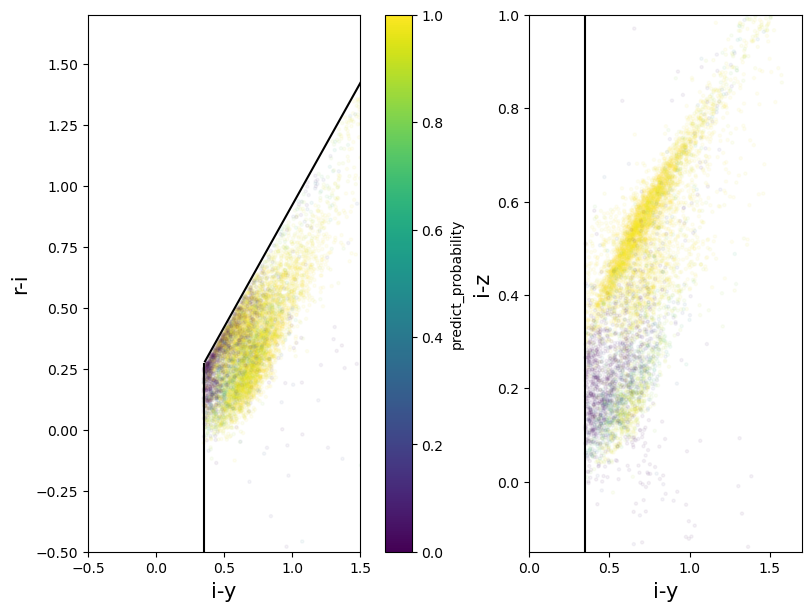

In [5]:
# #Color cuts i-y/r-i for final selection
# fig = colorsthres(xallb['iz'][color_cuts], 
# xallb['ri'][color_cuts], 
# xallb['iy'][color_cuts], 
# proballb_full[:, 1], 
# color_cuts, 
# iymin = 0.35, 
# xlim1 = (-0.5,1.5), 
# ylim1 = (-0.5, 1.7), 
# xlim2 = (0,1.7), 
# ylim2 = (-0.15, 1.0))

# def colorsthres(c1, c2, c3, prob, cmask, iymin, xlabel1 = 'i-y', 
#                              ylabel1 = 'r-i', xlabel2 = 'i-y', ylabel2 = 'i-z',
#                              title1 = '',
#                              title2 = '',
#                              xlim1= (-2, 2), 
#                              ylim1=(0, 3), xlim2 = (-2, 2), ylim2 = (0, 3),**c_kwargs):

fig, (ax1, ax2) = plt.subplots(figsize=(8,6), ncols=2,  constrained_layout = True)
    
sd1 = ax1.scatter(xallb['iy'][color_cuts], xallb['ri'][color_cuts], c=proballb_full[:, 1][color_cuts] , cmap = 'viridis', s = 5, alpha = .05 ,vmin=0, vmax=1)
sd2 = ax2.scatter(xallb['iy'][color_cuts], xallb['iz'][color_cuts], c=proballb_full[:, 1][color_cuts] , cmap = 'viridis', s = 5, alpha = .05, vmin=0, vmax=1)
sdummy = ax2.scatter(x = 100, y = 100, c=proballb_full[:, 1][0], cmap = 'viridis', s = 5, alpha = 1 ,vmin=0, vmax=1)
x = np.arange(0.28 , 2, .05)
ax1.plot(x + 0.08 ,x, c = 'black')
ax1.axvline(x = 0.35 , ymax = .35 , c = 'black') 
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.7)
ax1.set_xlabel('i-y', fontsize = 15)
ax1.set_ylabel('r-i', fontsize = 15)
ax2.set_xlim(0, 1.7)
ax2.set_ylim(-0.15, 1.0)
ax2.set_xlabel('i-y', fontsize = 15)
ax2.set_ylabel('i-z', fontsize = 15)
ax2.axvline(x = 0.35 , c = 'black') 
cbar = plt.colorbar(sdummy)
cbar.set_label('predict_probability')
#Save the figure to the paperfigs directory 
#plt.savefig('/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/paperfigs/2panelcolorcuts.png', dpi = 300)
    

    

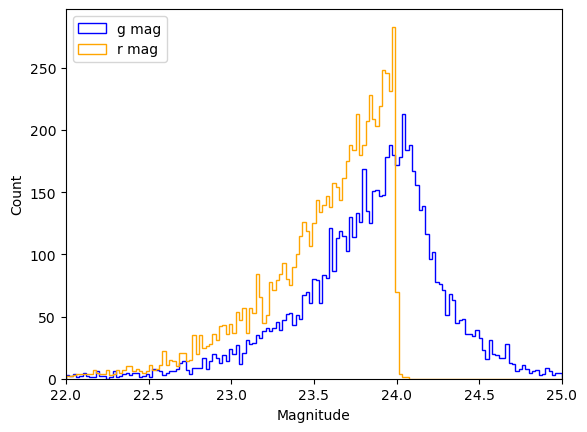

In [6]:
#Histogram of gband magnitude for broad zcut
#Overplot DESI ELG G Magnitude?
#Both r and g magnitude plots 
fig, ax3 = plt.subplots()

ax3.hist(xallb['HSC_g_MAG'][color_cuts], bins = np.linspace(22, 25, 150), histtype= 'step', label = 'g mag', color = 'blue')
ax3.hist(xallb['HSC_r_MAG'][color_cuts], bins = np.linspace(22, 25, 150), histtype= 'step', label = 'r mag', color = 'orange')
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Count')
ax3.set_xlim(22, 25)
ax3.legend(loc = 'upper left')


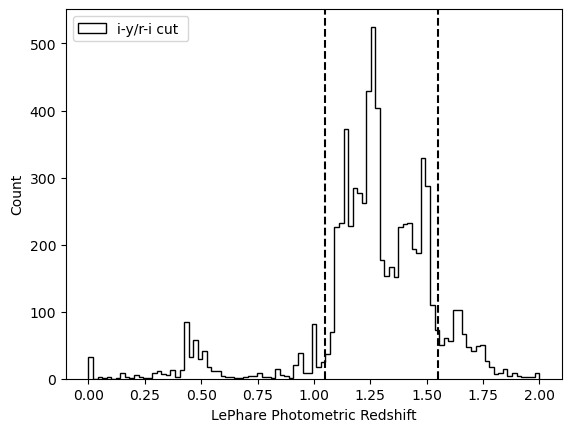

In [8]:
#Histogram of photozs for cat with broad zcut and color cuts
xallbz = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG', 'photoz']]
photoz =  cat.loc[colormaskx,['photoz']]
#Overplot DESI ELG Photoz distribution and make sure bin sizes match (Found in DESI ELG Target Selection Paper)

fig, ax4 = plt.subplots()

ax4.hist(photoz[color_cuts], bins = np.linspace(0, 2, 100), histtype= 'step', color = 'black', label = 'i-y/r-i cut ')
ax4.axvline(x = 1.05,ls= '--', color='black')
ax4.axvline(x = 1.55,ls= '--', color='black')
ax4.set_xlabel('LePhare Photometric Redshift')
ax4.set_ylabel('Count')
ax4.legend(loc = 'upper left')

In [86]:
#load in the desi specz ecsv file 
main_hsczphot = '/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/desi_elg_ts_zenodo/main-hsczphot-nz-zenodo.ecsv'
main_hsczphot_table = Table.read(main_hsczphot, format='ascii.ecsv') 
print(main_hsczphot_table.colnames)
desi_bin_center = main_hsczphot_table['REDSHIFT']
desi_bin_count = main_hsczphot_table['100PERC_LOWER_RISK_ZSPEC_HIST']
# print(desi_bin_center)
print(desi_bin_count)



['REDSHIFT', '100PERC_LOWER_RISK_ZSPEC_HIST', '100PERC_LOWER_RISK_ZPHOT_HIST', '50PERC_LOWER_RISK_ZSPEC_HIST', '50PERC_LOWER_RISK_ZPHOT_HIST', '25PERC_LOWER_RISK_ZSPEC_HIST', '25PERC_LOWER_RISK_ZPHOT_HIST']
100PERC_LOWER_RISK_ZSPEC_HIST
-----------------------------
          0.01104911330865698
          0.09800563504778742
          0.15104137892934086
           0.0685045025136733
          0.05137837688525497
          0.04353350643610846
          0.03613060051930834
         0.018452019225457163
         0.022540191149660244
          0.06452682172255678
                          ...
           0.8602839622120355
           0.5724545605215177
           0.5537815590298873
          0.19579028782940153
                          0.0
                          0.0
                          0.0
                          0.0
                          0.0
                          0.0
                          0.0
Length = 40 rows


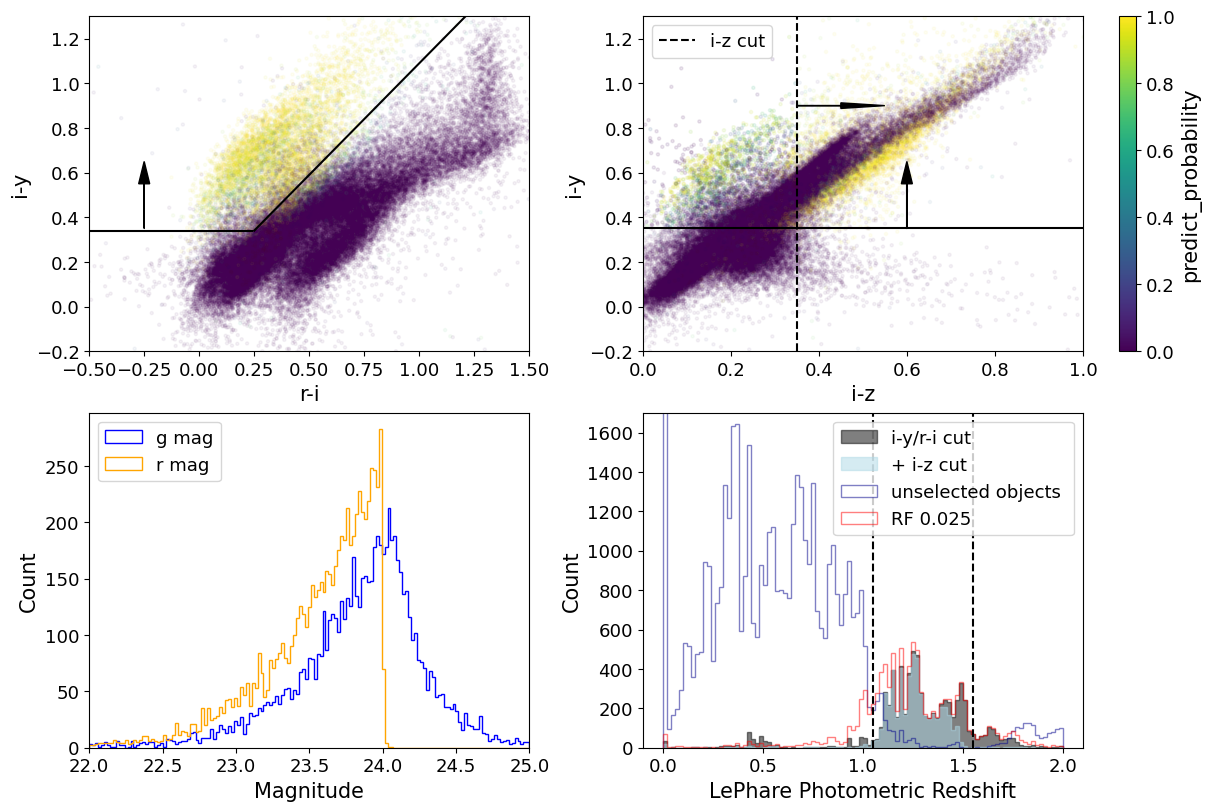

In [37]:
# colormaskx = np.logical_and.reduce((np.isfinite(cat['HSC_r_MAG']),
#                                     np.isfinite(cat['photoz']),
#                                     np.isfinite(cat['HSC_g_MAG']),np.isfinite(cat['HSC_i_MAG']),
#                                     np.isfinite(cat['HSC_y_MAG']),np.isfinite(cat['CFHT_u_MAG']),
#                                     np.isfinite(cat['HSC_z_MAG']),
#                                     (np.logical_or(cat['HSC_g_MAG']< 24, cat['HSC_r_MAG']< 24))))

# xallb = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]
# color_cuts = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1)) 

#setup a font size of 13 
plt.rcParams.update({'font.size': 13})

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,figsize=(12,8), ncols=2,  constrained_layout = True)

sd1 = ax1.scatter(xallb['ri'][color_cuts], xallb['iy'][color_cuts], c=proballb_full[:, 1][color_cuts] , cmap = 'viridis', s = 5, alpha = .05 ,vmin=0, vmax=1)
sd2 = ax2.scatter(xallb['iz'][color_cuts], xallb['iy'][color_cuts], c=proballb_full[:, 1][color_cuts] , cmap = 'viridis', s = 5, alpha = .05, vmin=0, vmax=1)
sdummy = ax2.scatter(x = 100, y = 100, c=proballb_full[:, 1][0], cmap = 'viridis', s = 5, alpha = 1 ,vmin=0, vmax=1)
x = np.arange(0.34 , 2, .05)
ax1.plot(x - 0.09 ,x, c = 'black')
ax1.scatter(xallb['ri'][unselected_iyri], xallb['iy'][unselected_iyri], c=proballb_full[:, 1][unselected_iyri] , cmap = 'viridis', s = 5, alpha = .05 ,vmin=0, vmax=1)
ax1.axhline(y = 0.34 , xmax = 0.37 , c = 'black') 
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.2, 1.3)
ax1.set_xlabel('r-i', fontsize = 15)
ax1.set_ylabel('i-y', fontsize = 15)

ax2.set_xlim(0, 1.0)
ax2.set_ylim(-0.2, 1.3)
ax2.set_xlabel('i-z', fontsize = 15)
ax2.set_ylabel('i-y', fontsize = 15)
ax2.axvline(x = 0.35 , ls= '--', color='black', label = 'i-z cut') 
ax2.axhline(y = 0.35 , color='black')
ax2.scatter(xallb['iz'][unselected_iz], xallb['iy'][unselected_iz], c=proballb_full[:, 1][unselected_iz] , cmap = 'viridis', s = 5, alpha = .05, vmin=0, vmax=1)
cbar = plt.colorbar(sdummy) 
cbar.set_label('predict_probability', fontsize = 15)
ax2.legend(loc = 'upper left')

ax3.hist(xallb['HSC_g_MAG'][color_cuts], bins = np.linspace(22, 25, 150), histtype= 'step', label = 'g mag', color = 'blue')
ax3.hist(xallb['HSC_r_MAG'][color_cuts], bins = np.linspace(22, 25, 150), histtype= 'step', label = 'r mag', color = 'orange')
ax3.set_xlabel('Magnitude', fontsize = 15)
ax3.set_ylabel('Count', fontsize = 15)
ax3.set_xlim(22, 25)
ax3.legend(loc = 'upper left')

ax4.hist(photoz[color_cuts], bins = np.linspace(0, 2, 101), histtype= 'step', color = 'black', label = 'i-y/r-i cut', fill = True, alpha = 0.5)
ax4.hist(photoz[iz_cut], bins = np.linspace(0, 2, 101)  , histtype = 'step', color = 'lightblue', label = '+ i-z cut', fill = True, alpha = 0.5)
ax4.hist(photoz[unselected_iyri], bins = np.linspace(0, 2, 101)  , histtype = 'step', color = 'darkblue', label = 'unselected objects ', alpha = 0.5)
ax4.hist(photoz[probmaskallb_full], bins = np.linspace(0, 2, 101)  , histtype = 'step', color = 'red', label = 'RF 0.025', alpha = 0.5)
#ax4.bar(desi_bin_center, desi_bin_count, color = 'green', label = 'DESI ELG objects', alpha = 0.5)
ax4.axvline(x = 1.05,ls= '--', color='black')
ax4.axvline(x = 1.55,ls= '--', color='black')
ax4.set_xlabel('LePhare Photometric Redshift', fontsize = 15)
ax4.set_ylabel('Count', fontsize = 15)
ax4.set_ylim(0, 1700)
ax4.legend(loc = 'upper right')
#draw arrows to show the cuts
ax1.arrow(-0.25, 0.35, 0, 0.2, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax2.arrow(0.60, 0.35, 0, 0.2, head_width=0.0250, head_length=0.1, fc='k', ec='k')
ax2.arrow(0.35, 0.9, 0.1, 0, head_width=0.0250, head_length=0.1, fc='k', ec='k')
#plt.tight_layout()


#Save the figure to the paperfigs directory
plt.savefig('/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/paperfigs/4panelcolorcuts.png', dpi = 300)
